<a href="https://colab.research.google.com/github/mwhite270/Predict_Eth_Ownership/blob/main/Ethereum_Ownership_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PREDICTION MODEL: ETHEREUM OWNERSHIP**
* This notebook was developed in Google Colab.
* The dataset used is owned by [The Omniacs DAO](https://github.com/Omni-Analytics-Group/).
* The model is built with PyTorch.
* The output is binary classification (Yes or No).

#Initializations and Data Loading

*   Import all python packages necessary to make, test, and use a PyTorch model.
*   Configure the use of a GPU or CPU.
* Mount a google drive to load a data file.




In [ ]:
import torch # Torch main framework
import torch.nn as nn # Used for getting the NN Layers
from torch.optim import Adam # Adam Optimizer
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from torchsummary import summary # Visualize the model layers and number of parameters
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
from sklearn.model_selection import train_test_split # Split the dataset (train, validation, test)
from sklearn.metrics import accuracy_score # Calculate the testing Accuracy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt # Plotting the training progress at the end
import pandas as pd # Data reading and preprocessing
import numpy as np # Mathematical operations
import platform
from google.colab import drive

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if platform.processor()=="arm" else 'cpu' # Detect the GPU if any. Otherwise use mps if Mac silicon, else use CPU
drive.mount('/content/drive') #mounting google drive where the data file will be stored (colab deletes local files after runtime ends)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load and Process the Dataset

* The dataset is read using pandas read_csv function.
* Placeholder values in columns are replaced with NaN.
* Nulls/missing data are removed.
* Features/Columns are rearranged for readability and standardization.
* Object variables are encoded to be numerical (the model requires this).
* Values are normalized to improve accuracy and computation.

```markdown
# README: Ethereum Ownership Prediction Model

This notebook develops a predictive model for Ethereum ownership. Below is a summary of its key components and functionalities:

*   **Purpose**: To predict whether an individual owns Ethereum based on various demographic and financial features.
*   **Development Environment**: Developed in Google Colab.
*   **Dataset**: The dataset used for training and evaluation is owned by [The Omniacs DAO](https://github.com/Omni-Analytics-Group/).
*   **Model Architecture**: The predictive model is built using PyTorch, a popular open-source machine learning framework.
*   **Output**: The model performs binary classification, meaning its output is either 'Yes' or 'No' regarding Ethereum ownership.
*   **Workflow**: The notebook includes sections for data loading and preprocessing, model setup (a simple Neural Network), training and validation, model testing, and an inference section for making predictions on new data.
```

In [ ]:
data_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/Eth_Ownership/data_raw.csv")  # Read the data (update this with your link)

# Replace the placeholder values in capital gain and hours per week columns.
data_df['capital_gain'] = data_df['capital_gain'].replace(99999, np.nan)
data_df['hours_per_week'] = data_df['hours_per_week'].replace(99, np.nan)

data_df.dropna(inplace = True) # Drop missing/null values

# Fill NaN values with 0
#data_df['capital_gain'].fillna(0, inplace=True)
#data_df['hours_per_week'].fillna(0, inplace=True)

In [ ]:
# Make the output variable column 'owns_ethereum' the last column. It's typical to have the output column as the last column.
data_df = data_df.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,12,11]]
print(data_df.info()) #Observing the columns have now been rearranged.

<class 'pandas.core.frame.DataFrame'>
Index: 45669 entries, 0 to 48841
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             45669 non-null  int64  
 1   workclass       45669 non-null  object 
 2   education_num   45669 non-null  int64  
 3   marital_status  45669 non-null  object 
 4   occupation      45669 non-null  object 
 5   relationship    45669 non-null  object 
 6   race            45669 non-null  object 
 7   sex             45669 non-null  object 
 8   capital_gain    45669 non-null  float64
 9   capital_loss    45669 non-null  int64  
 10  hours_per_week  45669 non-null  float64
 11  donated         45669 non-null  bool   
 12  owns_ethereum   45669 non-null  bool   
dtypes: bool(2), float64(2), int64(3), object(6)
memory usage: 4.3+ MB
None


In [ ]:
le = LabelEncoder() # Encodes the object/string columns to numeric.
original_values_with_labels = {}
# Select only the object type columns
object_cols = data_df.select_dtypes(include=['object','bool']).columns

for col in object_cols:
  data_df[col] = le.fit_transform(data_df[col])

  original_values_with_labels[col] = dict(zip(le.classes_, le.transform(le.classes_)))

print(data_df.head())

# Print the original values and their assigned numbers for each encoded column.
# This will be useful when setting up the infererence/user input for predictions.
for col, values_with_labels in original_values_with_labels.items():
    print(f"Original values and labels for '{col}':")
    for value, label in values_with_labels.items():
        print(f"  {value}: {label}")
    print("-" * 20)

print("="*50)
print(data_df.info()) #Observing the now encoded columns.

   age  workclass  education_num  marital_status  occupation  relationship  \
0   39          5             13               4           0             1   
1   50          4             13               2           3             0   
2   38          2              9               0           5             1   
3   53          2              7               2           5             0   
4   28          2             13               2           9             5   

   race  sex  capital_gain  capital_loss  hours_per_week  donated  \
0     4    1        2174.0             0            40.0        1   
1     4    1           0.0             0            13.0        1   
2     4    1           0.0             0            40.0        0   
3     2    1           0.0             0            40.0        0   
4     2    0           0.0             0            40.0        1   

   owns_ethereum  
0              1  
1              0  
2              0  
3              0  
4              1  
Or

In [ ]:
original_df = data_df.copy() # Creating a copy of the dataframe to use to normalize inference later.

In [ ]:
numeric_cols = data_df.select_dtypes(include=['int64', 'float64']).columns

scaler = MinMaxScaler() #Using MinMaxScaler from sklearn
#scaler = StandardScaler()

for col in numeric_cols:
  data_df[col] = scaler.fit_transform(data_df[[col]]) # Divide by the maximum of the column; which will make max value of each column be 1.

print(data_df.head()) #Observe the normalized/scaled values.

        age  workclass  education_num  marital_status  occupation  \
0  0.301370   0.833333       0.800000        0.666667    0.000000   
1  0.452055   0.666667       0.800000        0.333333    0.230769   
2  0.287671   0.333333       0.533333        0.000000    0.384615   
3  0.493151   0.333333       0.400000        0.333333    0.384615   
4  0.150685   0.333333       0.800000        0.333333    0.692308   

   relationship  race  sex  capital_gain  capital_loss  hours_per_week  \
0           0.2   1.0  1.0      0.052626           0.0        0.402062   
1           0.0   1.0  1.0      0.000000           0.0        0.123711   
2           0.2   1.0  1.0      0.000000           0.0        0.402062   
3           0.0   0.5  1.0      0.000000           0.0        0.402062   
4           1.0   0.5  0.0      0.000000           0.0        0.402062   

   donated  owns_ethereum  
0      1.0            1.0  
1      1.0            0.0  
2      0.0            0.0  
3      0.0            0.0  


# Split the Dataset for Model Training
* Data loading into NumPY arrays for improved compuation.
* SKlearn used to split the data into 70% for training, 15% for testing, and 15% for validation.
* Note: Alternatively, pandas could be used instead of converting to NumPy.

In [ ]:
# Data splitting into train, test, validation

X = np.array(data_df.iloc[:,:-1]) # Get the inputs -  all rows and all columns except the last column ('owns_ethereum')
Y = np.array(data_df.iloc[:, -1]) # Get the ouputs - all rows and only the last column (output)

# Alternative:separate features (X) and target (Y) using pandas DataFrames
#X = data_df.iloc[:,:-1] # Get the inputs -  all rows and all columns except the last column ('owns_ethereum')
#Y = data_df.iloc[:, -1] # Get the ouputs - all rows and only the last column (output)

# Split the data with sklearn
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 7) # Create the Training set split of 70% of the data.
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 14) # Remaining 30% of data is evenly split into Test and Validation sets.
print("Training set is: ", X_train.shape[0], " rows which is ", round(X_train.shape[0]/data_df.shape[0],4)*100, "%") # Print training shape
print("Validation set is: ",X_val.shape[0], " rows which is ", round(X_val.shape[0]/data_df.shape[0],4)*100, "%") # Print validation shape
print("Testing set is: ",X_test.shape[0], " rows which is ", round(X_test.shape[0]/data_df.shape[0],4)*100, "%") # Print testing shape

Training set is:  31968  rows which is  70.0 %
Validation set is:  6851  rows which is  15.0 %
Testing set is:  6850  rows which is  15.0 %


# Setup the Neural Network Model
* Converts data to tensors.
* PyTorch uses ".to(device)" to send variables to the GPU/CPU for computation.
* The simple Neural Network has a linear input layer that outputs a specified number of neurons to an output layer. The output layer has one output since this is a binary classification. The model uses a sigmoid activation function on the outlet layer.
* PyTorch DataLoader is used to simplify the training. Dataloader is an object that we can loop through to train according to batches.
* The BCELoss function (Binary Cross Entropy) is used to compute cost.
* Adam (Adaptive Moment Estimation) optimizer is used for gradient descent.


In [ ]:
#Creating a custom Dataset class. This is typical for PyTorch.
class dataset(Dataset):
    def __init__(self, X, Y):
        # X and Y here represent the data and labels (e.g., X_train, y_train)
        self.X = torch.tensor(X, dtype = torch.float32).to(device) # PyTorch tensors required dtype.
        self.Y = torch.tensor(Y, dtype = torch.float32).to(device)
        #self.X = torch.tensor(X.values, dtype = torch.float32).to(device)
        #self.Y = torch.tensor(Y.values, dtype = torch.float32).to(device)

    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [ ]:
#Converting Training, Validation, and Testing datasets to PyTorch objects.
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

In [ ]:
# Setting the training hyperparameters.
BATCH_SIZE = 32 #arbitrarily determined batch size.
HIDDEN_NEURONS = 12 #arbitrarily determined number of neurons.
EPOCHS = 50 #arbitrarily determined number of epochs.
LR = 1e-3 #Learning rate

In [ ]:
#Creating a custom Neural Network class. This is typical for PyTorch.
class nnModel(nn.Module):
    def __init__(self):

        super(nnModel, self).__init__()

        self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS) #Input is the number of features. Output is a the designated number of neurons.
        self.linear = nn.Linear(HIDDEN_NEURONS, 1) #Input is the number of inputs from the previous layer. Binary classification.
        self.sigmoid = nn.Sigmoid() #Activation function.

    def forward(self, x): #Forward propagation moves the data through the model
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [ ]:
#Running dataloader on the datasets converted to PyTorch objects.
#Shuffles to randomize the data and then loops through it in each epoch to train.
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle= True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle= True)
testing_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle= True)

In [ ]:
model = nnModel().to(device) # Instantiate the model and move it to the device.

# Print the model summary
summary(model, input_size=(X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 12]             156
            Linear-2                    [-1, 1]              13
           Sigmoid-3                    [-1, 1]               0
Total params: 169
Trainable params: 169
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [ ]:
criterion = nn.BCELoss() #Loss function.
optimizer = Adam(model.parameters(), lr= LR) #Gradient descent on the model parameters.

# Train and Validate the Model

* Model is looped for the specified number of epochs.
* The data in the Training dataloader is first looped in an epoch. Prediction, loss, accuracy, backpropagation, and gradient descent are done.
* The Validation dataloader is looped in the same epoch, with the model making predictions.
* The loss and accuracy of Training & Validation are totalized for each epoch. The results are output to show the training progression.

In [ ]:
total_loss_train_plot = [] #Creating a list with the Training loss for each epoch to use for visualiztion.
total_acc_train_plot = [] #Creating a list with Training accuracy for each epoch to use for visualiztion.
total_loss_validation_plot = [] #Creating a list with Validation loss for each epoch to use for visualiztion.
total_acc_validation_plot = [] #Creating a list with Validation accuracy for each epoch to use for visualiztion.

for epoch in range(EPOCHS):
    total_loss_train = 0 #zero out for each epoch.
    total_acc_train = 0 #zero out for each epoch.
    total_loss_val = 0 #zero out for each epoch.
    total_acc_val = 0 #zero out for each epoch.

    # Training set
    for data in train_dataloader:

        inputs, labels = data

        prediction = model(inputs).squeeze(1) #Modify the shape of the output to return a tensor with the correct dimensions.

        batch_loss = criterion(prediction, labels) #Calculating the loss of the predictions for each batch.

        total_loss_train += batch_loss.item() #Totalizing the loss for the loop.

        acc = ((prediction).round() == labels).sum().item() #Calculating accuracy of the predictions.

        total_acc_train += acc #Totalizing the accuracy of the looop.

        batch_loss.backward() #backpropagation
        optimizer.step() #gradient descent on the weights
        optimizer.zero_grad() #resetting optimizer gradients.

    # Validation set
    with torch.no_grad(): #Used to tell the model not to train - just make a prediction.
        for data in validation_dataloader:
            inputs, labels = data

            prediction = model(inputs).squeeze(1)

            batch_loss = criterion(prediction, labels)

            total_loss_val += batch_loss.item()

            acc = ((prediction).round() == labels).sum().item()

            total_acc_val += acc

    total_loss_train_plot.append(round(total_loss_train/1000, 4)) #appending the Training loss list
    total_acc_train_plot.append(round(total_acc_train/(training_data.__len__())*100, 4)) #appending the Training accuracy list
    total_loss_validation_plot.append(round(total_loss_val/1000, 4)) #appending the Validation loss list
    total_acc_validation_plot.append(round(total_acc_val/(validation_data.__len__())*100, 4)) #appending the Validation accuracy list

    print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(training_data.__len__())*100):.4f} Validation Loss: {total_loss_val/1000:.4f} Validation Accuracy: {(total_acc_val/(validation_data.__len__())*100):.4f}''')
    print("="*50)

Epoch no. 1 Train Loss: 0.4755 Train Accuracy: 80.5556 Validation Loss: 0.0851 Validation Accuracy: 87.1114
Epoch no. 2 Train Loss: 0.3610 Train Accuracy: 88.6105 Validation Loss: 0.0768 Validation Accuracy: 88.5272
Epoch no. 3 Train Loss: 0.3398 Train Accuracy: 89.0766 Validation Loss: 0.0745 Validation Accuracy: 88.3813
Epoch no. 4 Train Loss: 0.3313 Train Accuracy: 88.9921 Validation Loss: 0.0726 Validation Accuracy: 88.7754
Epoch no. 5 Train Loss: 0.3279 Train Accuracy: 88.8795 Validation Loss: 0.0721 Validation Accuracy: 88.5418
Epoch no. 6 Train Loss: 0.3254 Train Accuracy: 88.7731 Validation Loss: 0.0724 Validation Accuracy: 87.1844
Epoch no. 7 Train Loss: 0.3246 Train Accuracy: 88.6074 Validation Loss: 0.0717 Validation Accuracy: 88.2937
Epoch no. 8 Train Loss: 0.3246 Train Accuracy: 88.5135 Validation Loss: 0.0719 Validation Accuracy: 87.0968
Epoch no. 9 Train Loss: 0.3244 Train Accuracy: 88.5385 Validation Loss: 0.0714 Validation Accuracy: 88.4834
Epoch no. 10 Train Loss: 0.3

#Testing the Model

* Loops through the Testing dataloader - without doing any training.
* Loss and accuracy are totalized for the predictions.
* An accuracy score is output.

In [ ]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in testing_dataloader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)

    batch_loss_test = criterion((prediction), labels)
    total_loss_test += batch_loss_test.item()
    acc = ((prediction).round() == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/X_test.shape[0])*100, 2)}%")

Accuracy Score is: 88.48%


#Plot the Loss and Accuracy

Plotting the loss and accuracy for the Training and Validation sets for each epoch. This makes a good visual for bias and variance determination.

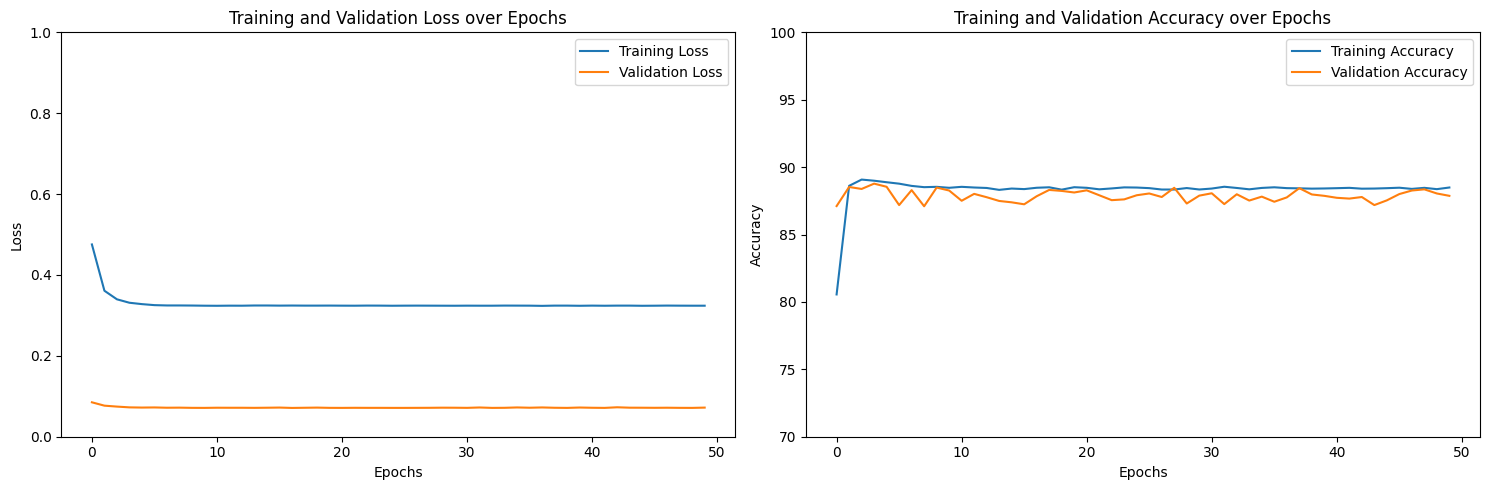

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 1])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([70, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

#Use the Model to Make a Prediction (Inference)

* Profile data is entered into the form.
* Profile entries are fed into the model.
* Model prediction is output as a "Yes" or "No" to owning Ethereum.

In [ ]:
# #Manual profile entry. This has been replaced in the notebook with a form entry.
# age = int(input("Age: "))
# workclass = str(input("workclass: "))
# education_num = int(input("education_num: "))
# marital_status = str(input("marital_status: "))
# occupation = str(input("occupation: "))
# relationship = str(input("relationship: "))
# race = str(input("race: "))
# sex = str(input("sex: "))
# capital_gain = float(input("capital_gain: "))
# capital_loss = float(input("capital_loss: "))
# hours_per_week = float(input("hours_per_week: "))
# donated = bool(input("donated: "))

In [ ]:
# @title Fill Out Profile for Prediction {"run":"auto","vertical-output":true,"display-mode":"form"}
# @title
age = 47 # @param {"type":"integer"}
workclass = "Self-emp-not-inc" # @param ["","Federal-gov","Local-gov","Never-worked","Private","Self-emp-inc","Self-emp-not-inc","State-gov","Without-pay"]
education_num = 14 # @param {"type":"integer"}
marital_status = "Never-married" # @param ["Never-married","Married-AF-spouse","Married-civ-spouse","Married-spouse-absent","Divorced","Separated","Widowed",""]
occupation = "Prof-specialty" # @param ["Adm-clerical","Armed-Forces","Craft-repair","Exec-managerial","Farming-fishing","Handlers-cleaners","Machine-op-inspct","Other-service","Priv-house-serv","Prof-specialty"," Protective-serv","Sales","Tech-support","Transport-moving",""]
relationship = "Not-in-family" # @param ["Husband","Not-in-family","Other-relative","Own-child","Unmarried","Wife",""]
race = "White" # @param ["Amer-Indian-Eskimo","Asian-Pac-Islander","Black","White","Other",""]
sex = "Female" # @param ["Female","Male"]
capital_gain = 0 # @param {"type":"number"}
capital_loss = 0 # @param {"type":"number"}
hours_per_week = 50 # @param {"type":"number"}
donated = True # @param {"type":"boolean"}

In [ ]:
#Normalizes a variable's value based on the min and max values of the corresponding column from the original DataFrame.
def normalize_entry(variable):
  variable_name = [name for name, value in globals().items() if value is variable][0]
  return (variable - original_df[variable_name].min()) //(original_df[variable_name].max() - original_df[variable_name].min())

In [ ]:
#Converts the entries into the values that the LabelEncoder had assigned.

match workclass:
  case "Federal-gov":
    workclass = 0
  case "Local-gov":
    workclass = 1
  case "Never-worked":
    workclass = 2
  case "Private":
    workclass = 3
  case "Self-emp-inc":
    workclass = 4
  case "Self-emp-not-inc":
    workclass = 5
  case "State-gov":
    workclass = 6
  case "Without-pay":
    workclass = 7
  case _: # Assuming you want to handle the string "nan" as a case
    workclass = 8
# workclass = (workclass - original_df["workclass"].min())//(original_df["workclass"].max() - original_df["workclass"].min())

match marital_status:
  case "Divorced":
    marital_status = 0
  case "Married-AF-spouse":
    marital_status = 1
  case "Married-civ-spouse":
 	  marital_status = 2
  case "Married-spouse-absent":
    marital_status = 3
  case "Never-married":
    marital_status = 4
  case "Separated":
    marital_status = 5
  case "Widowed":
    marital_status = 6
  case _: # Assuming you want to handle the string "nan" as a case
    marital_status = 7
# marital_status = (marital_status - original_df["marital_status"].min())//(original_df["marital_status"].max() - original_df["marital_status"].min())

match occupation:
  case "Adm-clerical":
    occupation = 0
  case "Armed-Forcese":
    occupation = 1
  case "Craft-repair":
 	  occupation = 2
  case "Exec-managerial":
    occupation = 3
  case "Farming-fishing":
    occupation = 4
  case "Handlers-cleaners":
   occupation = 5
  case "Machine-op-inspct":
    occupation = 6
  case "Other-service":
 	  occupation = 7
  case "Priv-house-serv":
    occupation = 8
  case "Prof-specialty":
    occupation = 9
  case " Protective-serv":
   occupation = 10
  case "Sales":
    occupation = 11
  case "Tech-support":
 	  occupation = 12
  case "Transport-moving":
    occupation = 13
  case _:
    occupation = 14
# occupation = (occupation - original_df["occupation"].min())//(original_df["occupation"].max() - original_df["occupation"].min())

match relationship:
  case "Husband":
    relationship = 0
  case "Not-in-family":
   relationship = 1
  case "Other-relative":
 	  relationship = 2
  case "Own-child":
    relationship = 3
  case "Unmarried":
    relationship = 4
  case "Wife":
   relationship = 5
  case _:
    relationship = 6
# relationship = (relationship - original_df["relationship"].min())//(original_df["relationship"].max() - original_df["relationship"].min())

match race:
  case "Amer-Indian-Eskimo":
    race = 0
  case "Asian-Pac-Islander":
    race = 1
  case "Black":
 	  race = 2
  case "Other":
    race = 3
  case "White":
   race = 4
  case _:
   race = 5
# race = (race - original_df["race"].min())//(original_df["race"].max() - original_df["race"].min())

match sex:
  case "Female":
    sex = 0
  case "Male":
    sex = 1
# sex = (sex - original_df["sex"].min())//(original_df["sex"].max() - original_df["sex"].min())

match donated:
  case False:
    donated = 0
  case True:
    donated = 1
# donated = (donated - original_df["donated"].min())//(original_df["donated"].max() - original_df["donated"].min())

#Use function to normalize all of the entries.
workclass = normalize_entry(workclass)
marital_status = normalize_entry(marital_status)
occupation = normalize_entry(occupation)
relationship = normalize_entry(relationship)
race = normalize_entry(race)
sex = normalize_entry(sex)
donated = normalize_entry(donated)

In [ ]:
my_inputs = [age, workclass, education_num, marital_status, occupation, relationship, race, sex, capital_gain, capital_loss,
             hours_per_week, donated] #Normalized form entries to be fed into the model.
# print("="*20)
model_inputs = torch.Tensor(my_inputs).to(device)
prediction = (model(model_inputs))
# print(prediction)
predval = "Yes" if round(prediction.item()) == 1 else "No" # >= 0.5 = Yes. < 0.5 = No
print("Do they own Ethereum: ", predval)

Do they own Ethereum:  Yes
